AKT figure 2

In [1]:
import os
import numpy as np
import tomlkit
import torch
import matplotlib.pyplot as plt
from DTransformer.data import KTData, Transform
from DTransformer.model import DTransformer


DATA_DIR = "../data"
data_name = 'assist09'

datasets = tomlkit.load(open(os.path.join(DATA_DIR, "datasets.toml")))
dataset = datasets[data_name]

test_data = KTData(os.path.join(DATA_DIR, dataset["test"]), dataset["inputs"])
data = test_data[12]

In [3]:
args = {'d_model': 128, 'n_heads': 8, 'n_know': 32, 'n_layers': 3, 'from_file': '../output/DT_assist09.pt'}

model = DTransformer(
    dataset["n_questions"],
    dataset["n_pid"],
    d_model=args['d_model'],
    n_heads=args['n_heads'],
    n_know=args['n_know'],
    n_layers=args['n_layers'],
)

model.load_state_dict(torch.load(args['from_file'], map_location=lambda s, _: s))
model.eval();

DTransformer(
  (q_embed): Embedding(124, 128)
  (s_embed): Embedding(2, 128)
  (q_diff_embed): Embedding(124, 128)
  (s_diff_embed): Embedding(2, 128)
  (p_diff_embed): Embedding(17752, 1)
  (block1): DTransformerLayer(
    (masked_attn_head): MultiHeadAttention(
      (q_linear): Linear(in_features=128, out_features=128, bias=True)
      (k_linear): Linear(in_features=128, out_features=128, bias=True)
      (v_linear): Linear(in_features=128, out_features=128, bias=True)
      (out_proj): Linear(in_features=128, out_features=128, bias=True)
    )
    (dropout): Dropout(p=0.05, inplace=False)
    (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (block2): DTransformerLayer(
    (masked_attn_head): MultiHeadAttention(
      (q_linear): Linear(in_features=128, out_features=128, bias=True)
      (k_linear): Linear(in_features=128, out_features=128, bias=True)
      (v_linear): Linear(in_features=128, out_features=128, bias=True)
      (out_proj): Linear(in_feature

In [7]:
q, s, pid = data.get('q', 's', 'pid')
q = q.unsqueeze(0)
s = s.unsqueeze(0)
if pid is not None:
    pid = pid.unsqueeze(0)
with torch.no_grad():
    _, z, _, (q_score, k_score) = model.predict(q, s, pid)
q_score.size(), k_score.size()

(torch.Size([1, 8, 183, 183]), torch.Size([1, 8, 183, 32, 183]))

In [16]:
def heat_map(alpha, figsize, cmap='hot'):
    n_head = len(alpha)
    fig, ax = plt.subplots(1, n_head, figsize=figsize)
    for i in range(n_head):
        im = ax[i].pcolormesh(alpha[i], edgecolors='w', linewidth=0.4, cmap=cmap)
        ax[i].invert_yaxis()
        ax[i].set_xticks(np.arange(0, alpha[i].shape[1]+1, 5))
        ax[i].set_yticks(np.arange(0, alpha[i].shape[0]+1, 5))
        # im = ax[i].imshow(alpha[i], cmap=cmap)
        # ax[i].set_xticks(np.arange(alpha[i].shape[1]+1)-0.5, minor=True)
        # ax[i].set_yticks(np.arange(alpha[i].shape[0]+1)-0.5, minor=True)
        # ax[i].grid(which='minor', color='w', linestyle='-', linewidth=0.4)
    cbar = plt.colorbar(im, ax=ax, location='right')

In [9]:
heads = [2, 4, 5, 6]
seq_len = 20

alpha_q = [q_score[0, i, :seq_len, :seq_len] for i in heads]

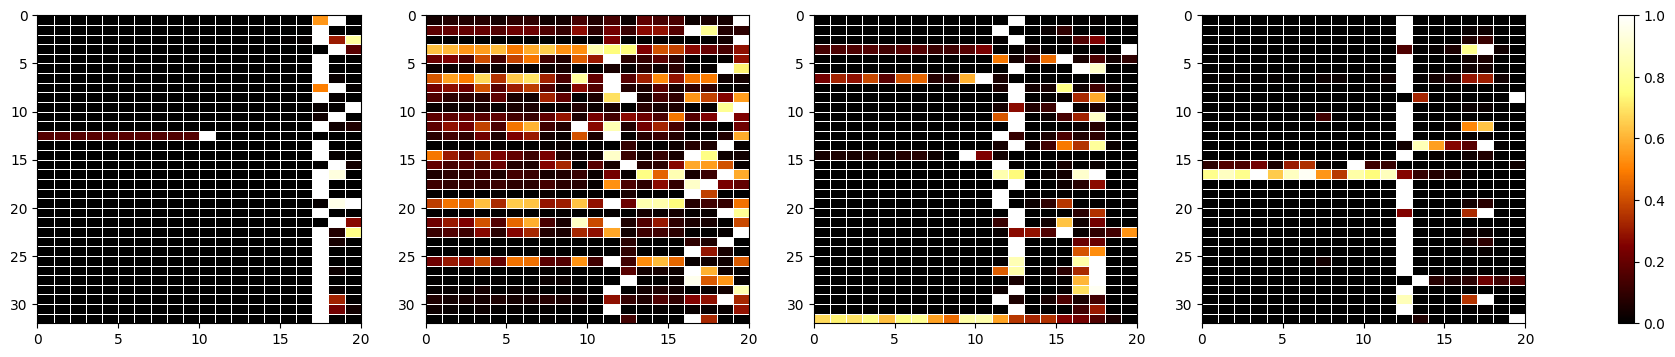

In [17]:
# 不同的head
alpha_k = [k_score[0, i, 20, :, :seq_len] for i in heads]
heat_map(alpha_k, figsize=(24, 4), cmap='afmhot')

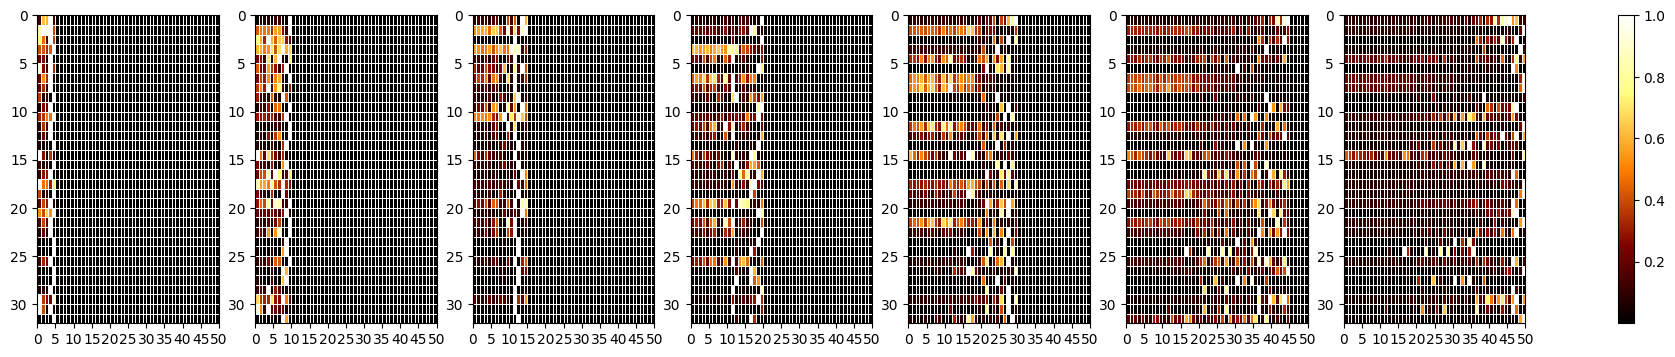

In [18]:
# 不同step
steps = [5, 10, 15, 20, 30, 45, 50]
alpha_k = [k_score[0, 4, i, :, :50] for i in steps]
heat_map(alpha_k, figsize=(24, 4), cmap='afmhot')

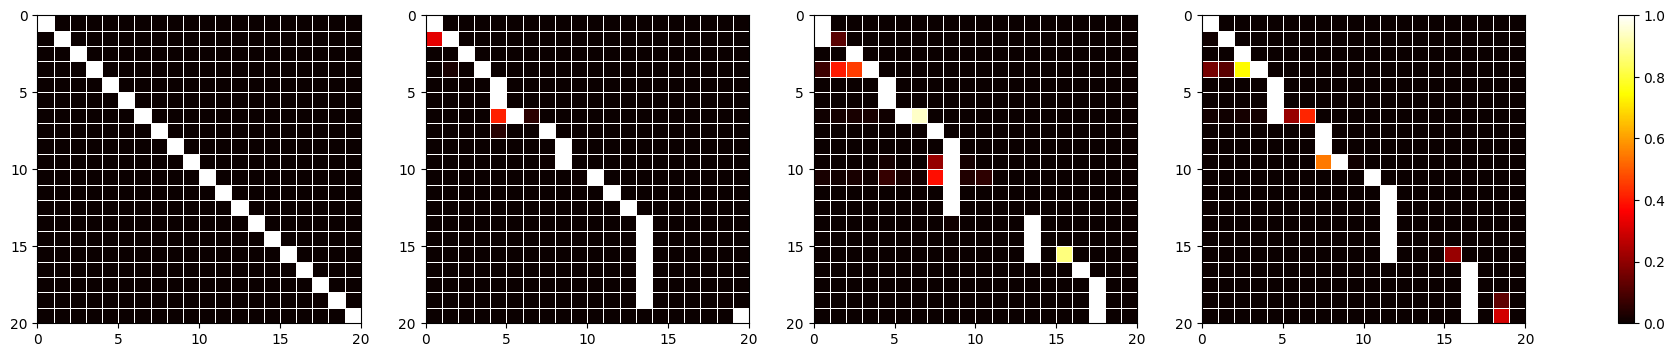

In [19]:
heat_map(alpha_q, figsize=(24, 4))

In [ ]:
def trace():
    